# Logistic Regression Decoding

The aim of this analysis is to decode the current choice of an animal, given recent task history. We will take information from the previous 10 trials such as previous choices, outcomes, start arms, reaction times, etc. and combine them in a linear way to decode the current choice.  

In a previous analysis, we did some dimensionality reduction with a Random Forest algorithm. We will try both the complete and reduced datasets. As for the logistic regression, we will use both L1 and L2 regularization. We will train all models and save them to folder 'HOME/Models/LR/L2' and 'HOME/Models/LR/L1' respectively. 

In [1]:
ROOT = '/Users/pablomartin/python/'

import os
import sys
sys.path.append(ROOT)
import pickle
import pandas as pd
import numpy as np
from scipy.stats import uniform
from behavioral_performance.utils \
import my_train_test_split, filename_to_label, ks_test_model
from behavioral_performance.kuiper import kuiper
from sklearn import linear_model
from Visualize.decoding \
import create_model_grid, plot_model_grid, plot_session_model_errors

data_full = ROOT + 'DATA_structures/TbyT_processed/'
data_reduced = ROOT + 'DATA_structures/TbyT_reduced_features/'
data2target = {data_full: 'full_features/', data_reduced: 'reduced_features/'}


idx = pd.IndexSlice
RANDOM_STATE = 77


## Training Model

Above is the 'boilerplate' code, just making sure we have all the functions we want. Now, we fit a logistic regression to the training data. We are using our custom train_test_split function because we want to split the sets so that we leave entire sessions left for testing. The regression essentially treats every trial the same, and uses the same function for the 2nd trial of the session or after 7 reversals. It is very important to keep track of how we split the data, which is capture by the RANDOM_STATE variable, which is fed as the random seed before the data is shuffled.  

The great thing about logistic regressions is that they're fast.

In [2]:
#trying both L1 and L2 regularization
for regularization in [1, 2]:
    target = ROOT + 'Models/LR/L%i/' %regularization
    clf = linear_model.LogisticRegression(penalty = 'l%i' %regularization)
    #picking appropriate dataset
    for dataset_source in [data_full, data_reduced]:
        #going thru each dataset
        for dataset in [f for f in os.listdir(dataset_source) if f[0] != '.']:

            task, regime = filename_to_label(dataset)
            print 'processing: %s - %s - L%i' %(task, regime, regularization)
            

            x, y = pickle.load(open(dataset_source + dataset, 'rb'))
            
            #split into training and testing 
            train_slice, test_slice = \
                    my_train_test_split(x, test_size = 0.2, RANDOM_STATE = RANDOM_STATE)
            x_train = x.loc[train_slice, :]
            y_train = y.loc[train_slice]
            
            clf.fit(x_train, y_train)
            #we can now know which way the data was split when this model was trained
            clf.RANDOM_STATE = RANDOM_STATE
            
            final_path = target + data2target[dataset_source] + dataset    
            pickle.dump(clf, open(final_path, 'wb'))
        
print 'DONE'

processing: PSR - Saline - L1
processing: PSR - FirstTraining - L1
processing: PSR - MPFC - L1
processing: PSR - Ipsi - L1
processing: DSR - Saline - L1
processing: DSR - Ipsi - L1
processing: PSR - Contra - L1
processing: DSR - FirstTraining - L1
processing: DSR - MPFC - L1
processing: PSR - OFC - L1
processing: PSR - MidTraining - L1
processing: DSR - MidTraining - L1
processing: DSR - OFC - L1
processing: DSR - Contra - L1
processing: PSR - Saline - L1
processing: PSR - FirstTraining - L1
processing: PSR - MPFC - L1
processing: PSR - Ipsi - L1
processing: DSR - Saline - L1
processing: DSR - Ipsi - L1
processing: PSR - Contra - L1
processing: DSR - FirstTraining - L1
processing: DSR - MPFC - L1
processing: PSR - OFC - L1
processing: PSR - MidTraining - L1
processing: DSR - MidTraining - L1
processing: DSR - OFC - L1
processing: DSR - Contra - L1
processing: PSR - Saline - L2
processing: PSR - FirstTraining - L2
processing: PSR - MPFC - L2
processing: PSR - Ipsi - L2
processing: DSR -

## Model Evaluation

We've trained a logistic regression model for both version of each dataset (full and reduced features). We've also trained 2 separate models, one with L1 and the other with L2 regularization. It is time to evaluate the performance of each model on itself and the other datasets.  

We will visualize it via the plot we are calling the "model grid". It is a heatmap of models tested on their own test set or other datasets. The more yellow the color, the more accurate it was. The bluer it is, the more inaccurate. Since there are 2 options for this task, 0.50 is random performance or terrible decoding. 

In [8]:

def populate_model_grid(model_dir, dataset_source):

    scores = create_model_grid()
    for model in os.listdir(model_dir):
        clf = pickle.load(open(model_dir + model, 'rb'))
        task_model, regime_model = filename_to_label(model)

        for dataset in [f for f in os.listdir(dataset_source) if f[0] != '.']:
            
            #get dataset labels
            task_data, regime_data = filename_to_label(dataset)
            
            #open dataset
            x, y = pickle.load(open(dataset_source + dataset, 'rb'))

            
            #if model is testing on its own data, we must test on the test set only !
            if task_model == task_data and regime_model == regime_data:
                #split into training and testing 
                train_slice, test_slice = \
                        my_train_test_split(x, test_size = 0.2, RANDOM_STATE = clf.RANDOM_STATE)
                
                score = clf.score(x.loc[test_slice, :], y.loc[test_slice])
            else: #we can use all dataset to test model
                score = clf.score(x, y)

            scores.loc[idx[task_model, regime_model],
                       idx[task_data, regime_data]] = score
    return scores

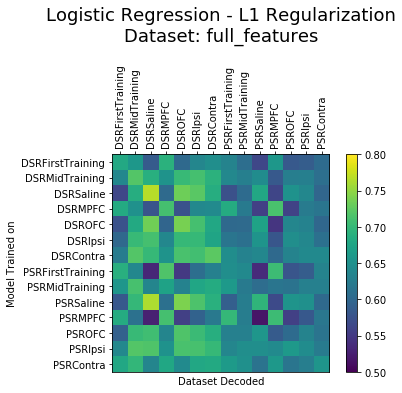

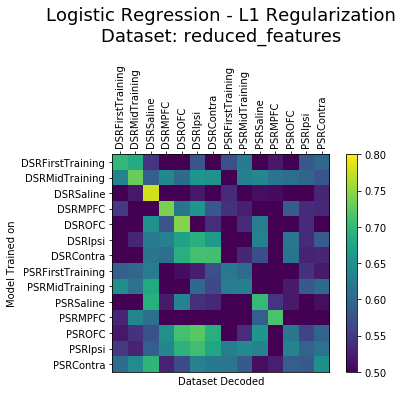

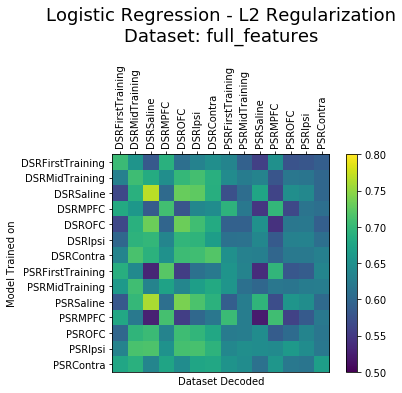

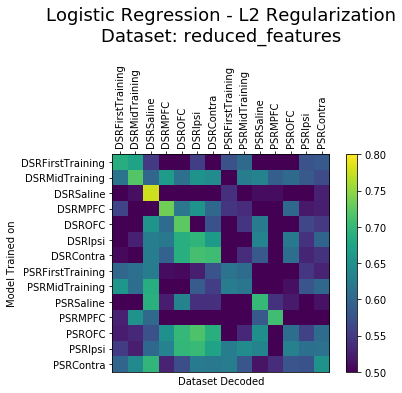

In [9]:

for regularization in [1, 2]:
    for dataset_source in [data_full, data_reduced]:
        
        model_dir = ROOT + 'Models/LR/L%i/%s/' \
                %(regularization, data2target[dataset_source])
        
        scores = populate_model_grid(model_dir, dataset_source)
        title = 'Logistic Regression - L%i Regularization\nDataset: %s' \
                %(regularization, data2target[dataset_source][:-1])
        plot_model_grid(scores, [0.5, 0.8], title=title)


## Model Evaluation Per Session

The first thing I notice is that decoding accuracy is not *amazing*. In fact, the highest any model did is around 0.80 decoding accuracy. In general, models along the diagonal should perform the highest, and that's more true for the dataset with the reduced input feature space. Also, these values tend to be in 0.70s range. Also, L1 or L2 regularization don't seem to be too different. For this reason, we will carry on our analysis only looking at L2 models. The dimensionality reduction we did with random forests should have done enough of clearing variables that were not as predictive, so presumably we won't be taking advantage of this feature of L1 as much. In any case, they seem to perform the same, so we'll keep it simple and only look at L2 from here. 


## Kolmogorov - Smirnov and Kuiper's Tests

If the model makes mistakes due to the randomness inherent in behavioral tasks, then that's ok. If the model, however, just repeats the previous choice and switches once the contingency changes, then we're not satisfied. Specifically, I want to know if the mistakes that the model is making "cluster" around specific behaviorally relevant parts of the task, e.g. right after a reversal. If the miscoded trials came at random times in the session, then we could say that they approximate a uniform distribution over [1, #trials in the session]. If they cluster around regions too much, they would differ from a uniform distribution.  

To determine whether decoding errors are 'clustering', we will perform a Kolmogorov-Smirnov (KS) test against the uniform distribution. If we can reject the hypothesis that they come from the same distribution, we will conclude that the model is not capturing the behavior well enough.  

A complementary test we can perform is Kuiper's test, which is highly related to KS test above. A difference is that it is cyclic invariant and particularly well-suited for circular distributions. We can check whether miscoded trials cluster around the beginning, middle, or end of a block. We take every block and turn it into a 'circle', the beginning of the block being 0 and the end 2\pi, and so the position of every error within the block becomes an angle. Then we have a distribution of angles around a circle, and we can perform Kuiper's test for periodic uniformity. It will be the case that some sessions will pass one or the other test as they measure different things. One tests uniformity throughout the session (KS), the other uniformity throughout the block (Kuiper's). 

## Visualize Sessions

How are these models making their predictions ? We will analyze this by looking at the test set, which is made up of *full* sessions, and plot a smooth learning curve of the actual behavior vs. the behavior predicted by the model. We are also interested in *where* the model miscoded the animal's choices, which we will mark with red x's on the same plot. 

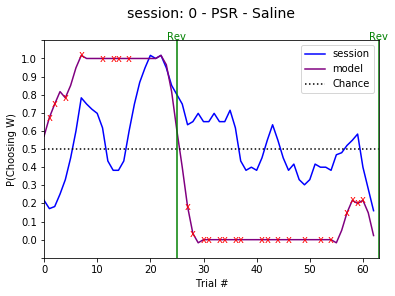

*****KS PASSED - p: 0.71******
***Kuiper PASSED - p: 1.00****


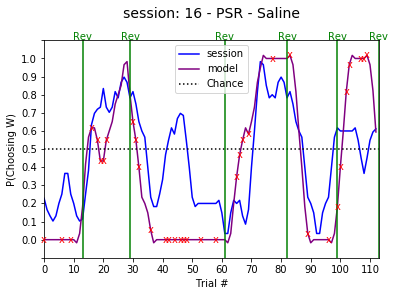

*****KS PASSED - p: 0.94******
***Kuiper PASSED - p: 0.84****


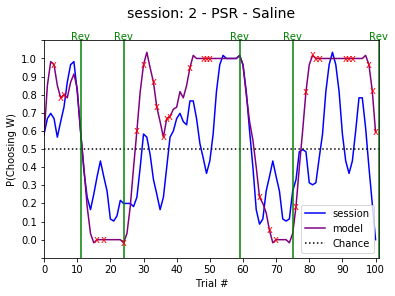

*****KS PASSED - p: 0.87******
***Kuiper PASSED - p: 0.35****


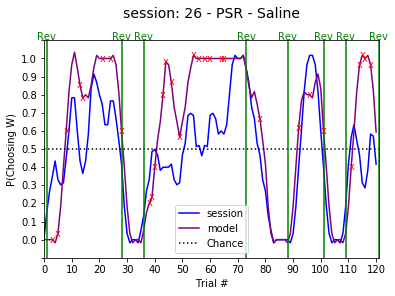

*****KS PASSED - p: 0.37******
***Kuiper PASSED - p: 1.00****


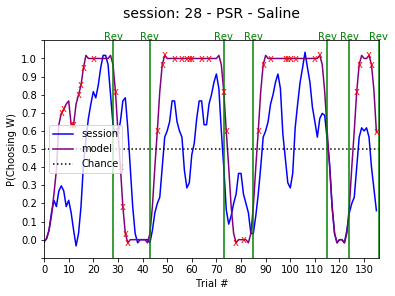

*****KS PASSED - p: 0.93******
***Kuiper PASSED - p: 1.00****


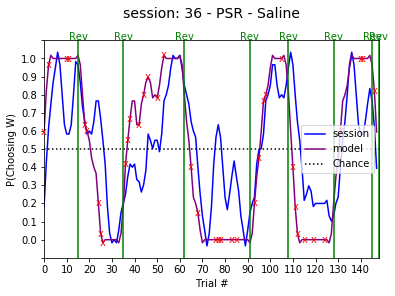

*****KS PASSED - p: 0.97******
***Kuiper PASSED - p: 0.99****


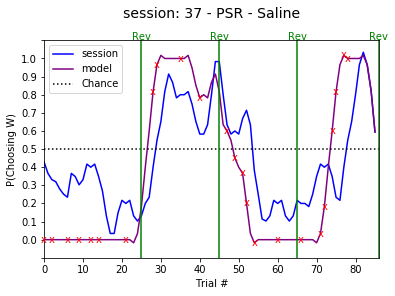

*****KS PASSED - p: 0.99******
***Kuiper PASSED - p: 1.00****


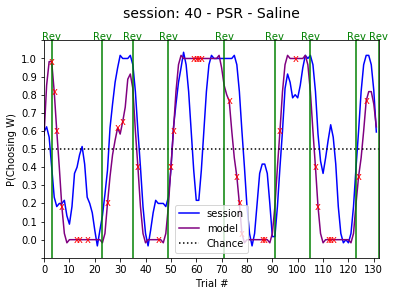

*****KS PASSED - p: 0.98******
***Kuiper PASSED - p: 0.99****


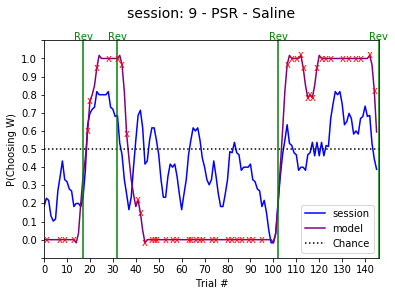

*****KS PASSED - p: 0.95******
***Kuiper FAILED - p: 0.00****


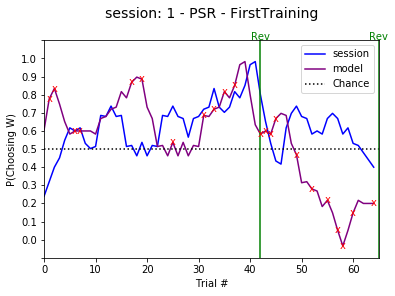

*****KS PASSED - p: 0.60******
***Kuiper FAILED - p: 0.00****


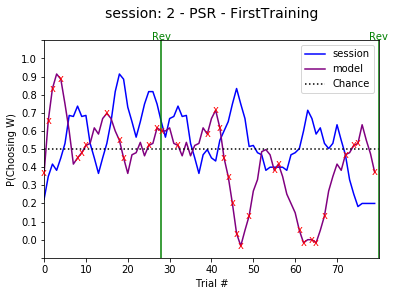

*****KS PASSED - p: 0.98******
***Kuiper PASSED - p: 0.87****


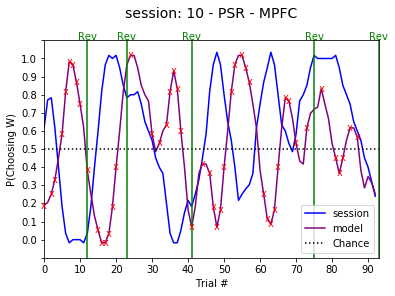

*****KS PASSED - p: 0.52******
***Kuiper PASSED - p: 0.40****


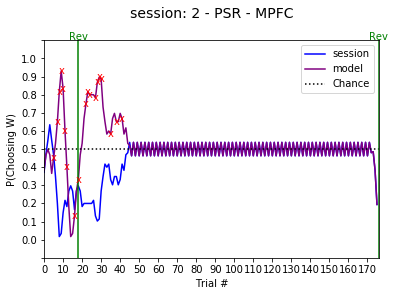

*****KS FAILED - p: 0.00******
***Kuiper PASSED - p: 1.00****


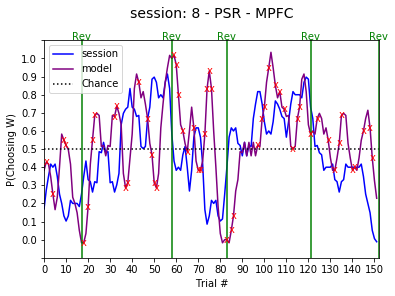

*****KS PASSED - p: 0.97******
***Kuiper PASSED - p: 0.96****


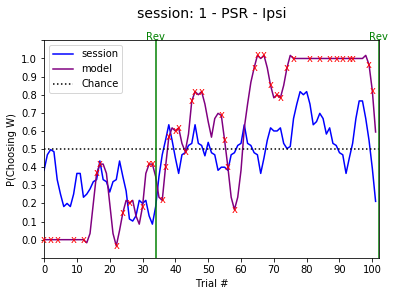

*****KS PASSED - p: 1.00******
***Kuiper PASSED - p: 0.46****


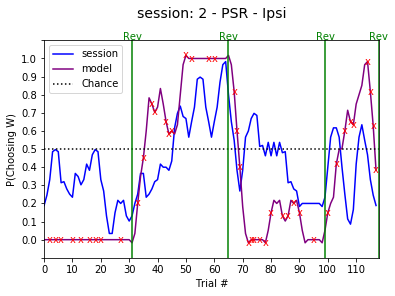

*****KS PASSED - p: 0.76******
***Kuiper PASSED - p: 0.28****


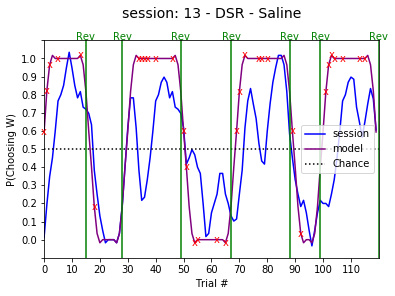

*****KS PASSED - p: 0.89******
***Kuiper PASSED - p: 0.97****


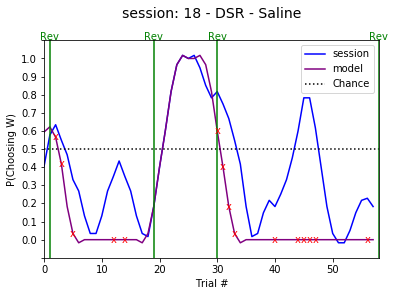

*****KS PASSED - p: 0.65******
***Kuiper PASSED - p: 0.69****


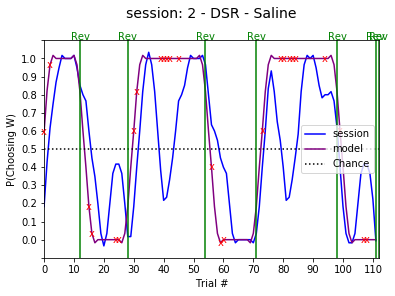

*****KS PASSED - p: 0.96******
***Kuiper PASSED - p: 0.99****


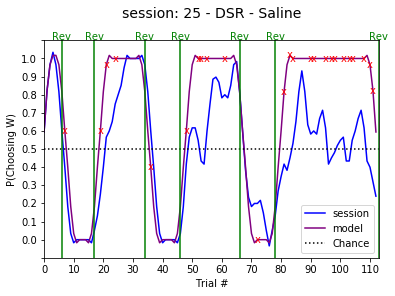

*****KS FAILED - p: 0.03******
***Kuiper PASSED - p: 0.54****


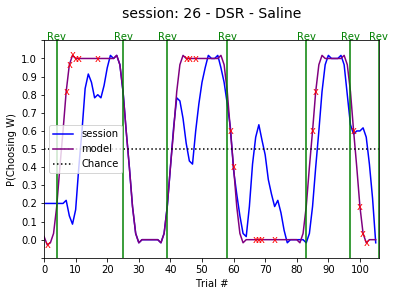

*****KS PASSED - p: 0.51******
***Kuiper PASSED - p: 0.91****


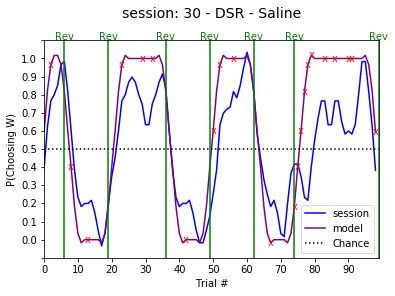

*****KS PASSED - p: 0.11******
***Kuiper PASSED - p: 0.89****


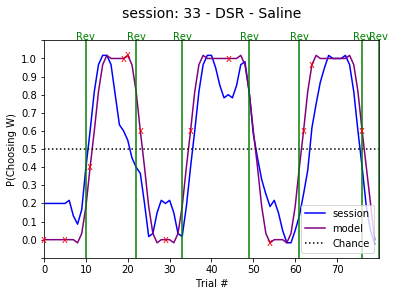

*****KS PASSED - p: 0.81******
***Kuiper PASSED - p: 0.98****


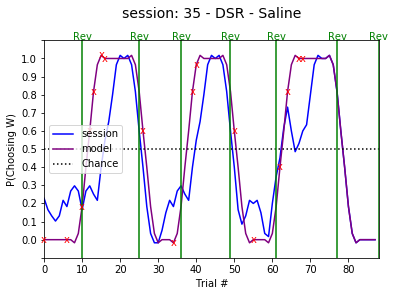

*****KS PASSED - p: 0.28******
***Kuiper PASSED - p: 0.55****


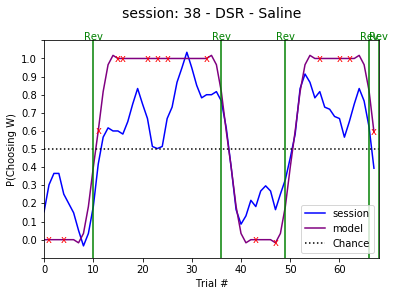

*****KS PASSED - p: 0.80******
***Kuiper PASSED - p: 0.37****


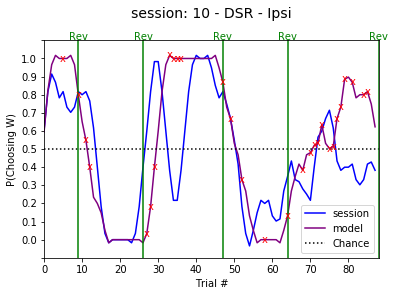

*****KS PASSED - p: 0.10******
***Kuiper PASSED - p: 0.95****


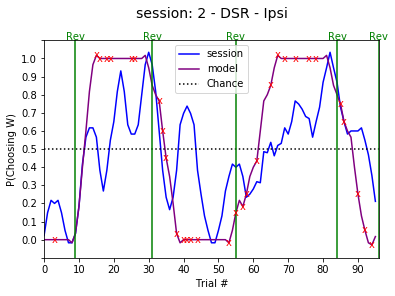

*****KS PASSED - p: 0.71******
***Kuiper PASSED - p: 1.00****


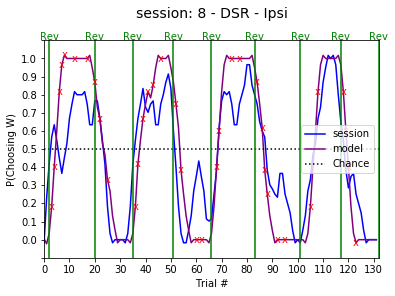

*****KS PASSED - p: 0.73******
***Kuiper PASSED - p: 1.00****


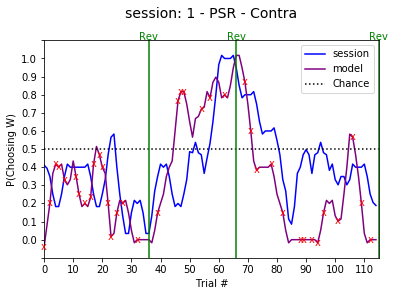

*****KS PASSED - p: 0.13******
***Kuiper PASSED - p: 1.00****


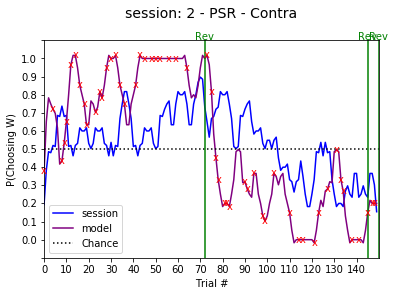

*****KS PASSED - p: 0.67******
***Kuiper FAILED - p: 0.01****


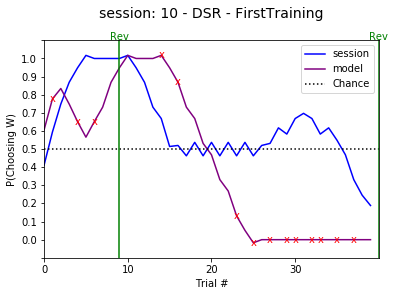

*****KS PASSED - p: 0.46******
***Kuiper PASSED - p: 0.26****


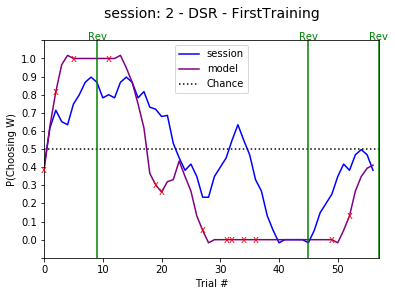

*****KS PASSED - p: 0.53******
***Kuiper PASSED - p: 0.71****


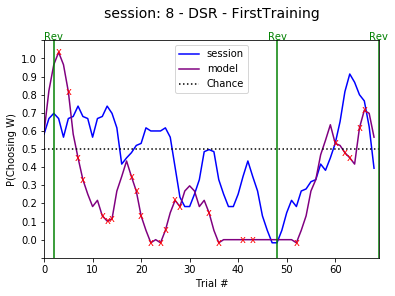

*****KS PASSED - p: 0.27******
***Kuiper FAILED - p: 0.00****


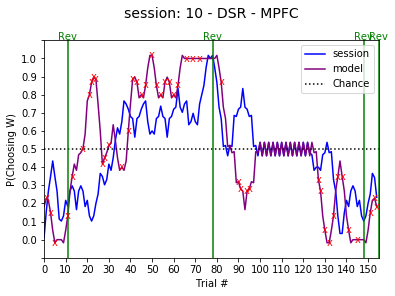

*****KS PASSED - p: 0.14******
***Kuiper FAILED - p: 0.00****


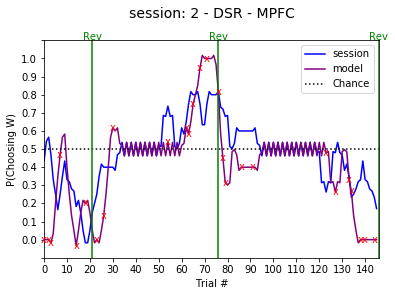

*****KS PASSED - p: 0.76******
***Kuiper PASSED - p: 0.69****


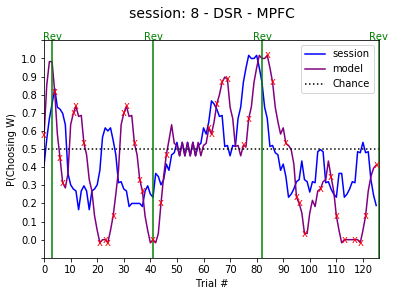

*****KS PASSED - p: 0.71******
***Kuiper PASSED - p: 1.00****


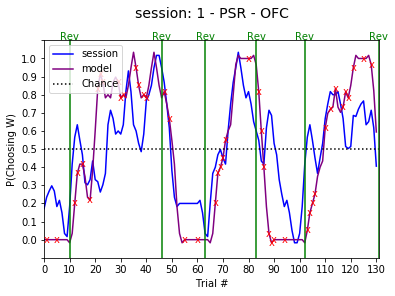

*****KS PASSED - p: 0.95******
***Kuiper PASSED - p: 1.00****


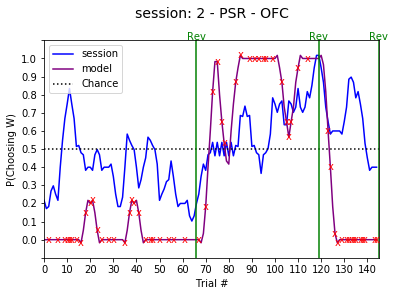

*****KS PASSED - p: 0.69******
***Kuiper PASSED - p: 1.00****


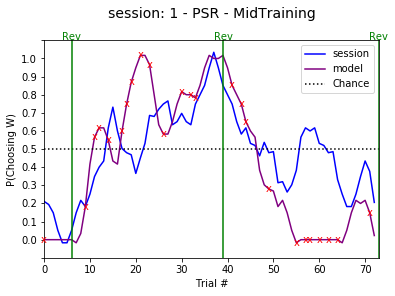

*****KS PASSED - p: 0.93******
***Kuiper FAILED - p: 0.03****


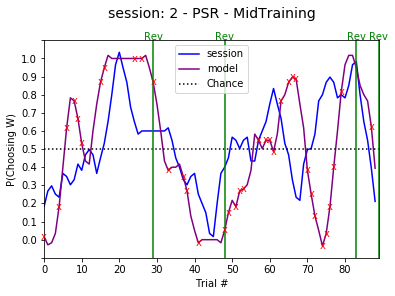

*****KS PASSED - p: 0.49******
***Kuiper PASSED - p: 0.89****


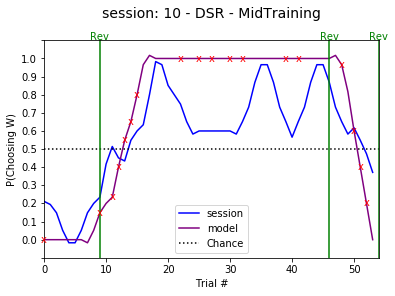

*****KS PASSED - p: 0.98******
***Kuiper FAILED - p: 0.04****


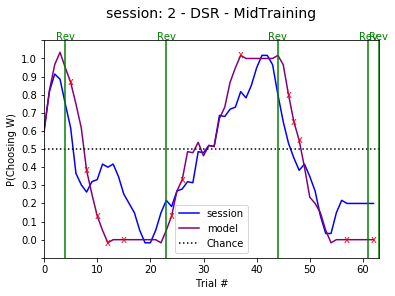

*****KS PASSED - p: 0.94******
***Kuiper PASSED - p: 0.13****


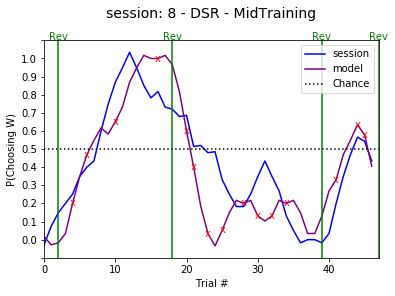

*****KS PASSED - p: 0.84******
***Kuiper PASSED - p: 0.83****


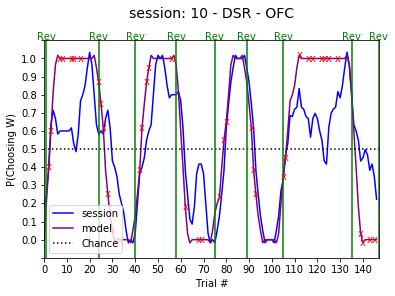

*****KS PASSED - p: 0.68******
***Kuiper PASSED - p: 1.00****


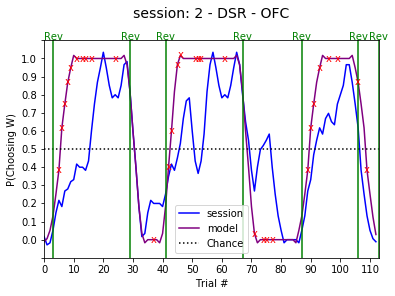

*****KS PASSED - p: 0.46******
***Kuiper PASSED - p: 1.00****


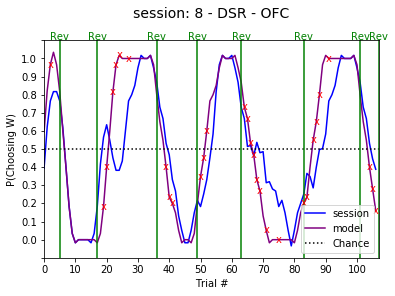

*****KS PASSED - p: 0.35******
***Kuiper PASSED - p: 0.66****


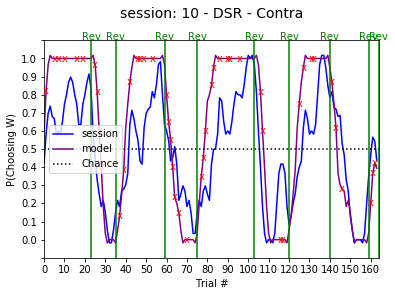

*****KS PASSED - p: 0.41******
***Kuiper PASSED - p: 0.67****


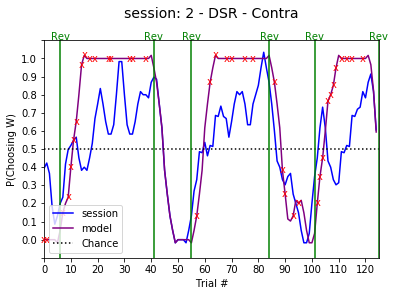

*****KS PASSED - p: 0.46******
***Kuiper PASSED - p: 1.00****


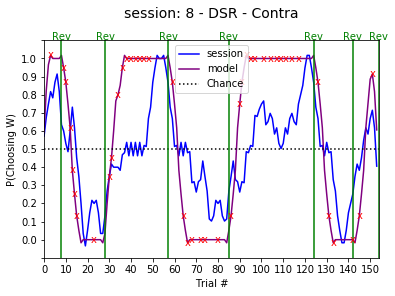

*****KS PASSED - p: 0.72******
***Kuiper PASSED - p: 0.27****


In [2]:
ROOT = '/Users/pablomartin/python/'
data_reduced = ROOT + 'DATA_structures/TbyT_reduced_features/'
model_dir = ROOT + 'Models/LR/L%i/%s/' %(2, 'reduced_features/')

idx = pd.IndexSlice
failedSessions = dict()
for model in os.listdir(model_dir):
    clf = pickle.load(open(model_dir + model, 'rb'))
    task, regime = filename_to_label(model)
    #open dataset
    x, y = pickle.load(open(data_reduced + model, 'rb'))
    
    #split into training and testing 
    train_slice, test_slice = \
        my_train_test_split(x, test_size = 0.2, RANDOM_STATE = clf.RANDOM_STATE)
    
    x_test = x.loc[test_slice, :]
    y_test = y.loc[test_slice]
    failedSessions[task+regime] = [0,0,0]
    session_test = x_test.groupby(axis = 0, level = 'session')
    #go thru each test set session
    for sessName, sess in session_test:
        #processing actual and predicted choices
        modelPredictions = clf.predict(sess)
        session = pd.concat([sess, y_test.loc[idx[sessName,:,:]]], axis=1)
        title = 'session: %s - %s - %s\n' %(sessName[1:], task, regime)
        #we average over moving window, then apply Savitzky-Golay filter 
        plot_session_model_errors(session, modelPredictions, window_size = 5, title = title)
        #Kolmogorov - Smirnov test
        errorDecoding = np.nonzero(modelPredictions != session['choice', 0])[0]
        p = ks_test_model(errorDecoding, len(session))
        #Kuiper's test
        blocks = session.groupby(axis=0, level = 'block')
        blockLengths = [len(l) for b,l in blocks]
        blockIndex = [0] + list(np.cumsum(blockLengths))
        angles = []
        for bindex in range(len(blockIndex) - 1):
            tmp_block_length = blockLengths[bindex]
            tmp_slice = errorDecoding[blockIndex[bindex] : blockIndex[bindex + 1]]
            angles += list((np.nonzero(tmp_slice)[0] / np.float(tmp_block_length)))
        D, p_kuiper = kuiper(angles, uniform.cdf)
            
        if p < 0.05: 
            print '{:*^30}'.format('KS FAILED - p: %1.2f' %p)
            failedSessions[task+regime][0] += 1
        else: print '{:*^30}'.format('KS PASSED - p: %1.2f' %p)
        if p_kuiper < 0.05: 
            print '{:*^30}'.format('Kuiper FAILED - p: %1.2f' %p_kuiper)
            failedSessions[task+regime][1] += 1
        else: print '{:*^30}'.format('Kuiper PASSED - p: %1.2f' %p_kuiper)
        failedSessions[task+regime][2] += 1

## Some Interpretation 

First thing that stands out to me is that the model (purple line) generally does follow the actual data (blue line). Where it fails is in that it stays pretty flat once it's made up its mind that a reversal happened. This means that the model is probably just outputting the same choice for many consecutive trials. Most sessions, however, passed both KS and Kuiper's test. This will be a good additional tool to evaluate the performance of our models. Clearly decoding accuracy on the test set is important, but we also care about *how* the model does when it's not decoding correctly. Finally, a quick quantification of how many sessions failed which test with logistic regression on the reduced dataset, with L2 regularization:

In [15]:
for regime in failedSessions.keys():
    print '%s - %s' %(regime[:3], regime[3:])
    print 'failed KS: %i - failed Kuiper: %i - total sessions: %i' %tuple(failedSessions[regime])

PSR - Contra
failed KS: 0 - failed Kuiper: 1 - total sessions: 2
DSR - MidTraining
failed KS: 0 - failed Kuiper: 1 - total sessions: 3
DSR - OFC
failed KS: 0 - failed Kuiper: 0 - total sessions: 3
DSR - MPFC
failed KS: 0 - failed Kuiper: 1 - total sessions: 3
DSR - FirstTraining
failed KS: 0 - failed Kuiper: 1 - total sessions: 3
PSR - FirstTraining
failed KS: 0 - failed Kuiper: 1 - total sessions: 2
DSR - Contra
failed KS: 0 - failed Kuiper: 0 - total sessions: 3
DSR - Saline
failed KS: 1 - failed Kuiper: 0 - total sessions: 9
PSR - OFC
failed KS: 0 - failed Kuiper: 0 - total sessions: 2
PSR - Saline
failed KS: 0 - failed Kuiper: 1 - total sessions: 9
PSR - MidTraining
failed KS: 0 - failed Kuiper: 1 - total sessions: 2
PSR - MPFC
failed KS: 1 - failed Kuiper: 0 - total sessions: 3
DSR - Ipsi
failed KS: 0 - failed Kuiper: 0 - total sessions: 3
PSR - Ipsi
failed KS: 0 - failed Kuiper: 0 - total sessions: 2


Since we don't have so many test sessions, since for most datasets we only have ~11 sessions, we get some semi-troubling results of 1 fail out of 2 or 3 sessions. This, coupled with the low decoding rates, may push us in another direction, maybe recurrent neural networks. A final analysis we may include here, in the future, is a test of how 'coupled' some datasets are. Intuitively, we want to know how similar 2 datasets are. The idea is that if a model trained on one performs well on the other, and vice versa, then the datasets are similar, or in other words, rats are making choices in a *similar way*. At the moment, I need to do more research on what methods are available for that type of analysis. 